In [1]:
%run setup_notebook.ipynb

ERROR:root:File `'setup_notebook.ipynb.py'` not found.


In [2]:
# general imports
import sys
sys.path.append('/home/thijs/repos/Vape/')
sys.path.append('/home/thijs/repos/Vape/utils')
sys.path.append('/home/thijs/repos/Vape/jupyter/')
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils_funcs as utils
import run_functions as rf
from subsets_analysis import Subsets
import pickle
from dPCA import dPCA

In [4]:
## Load data

# dictionary of mice and run numbers to analyse
run_dict = {
            'J048' : [27, 29, 30, 32], 
            'RL048': [23, 24, 25, 28, 29]
           }

# local path to behaviour pickle files
# this takes a while to load so maybe should do some further caching in the future
# pkl_path = '/home/jamesrowland/Documents/Code/Vape/run_pkls/'
pkl_path = '/run/user/1000/gvfs/smb-share:server=qnap-amp001.dpag.ox.ac.uk,share=jrowland/'\
            'run_pkls'

runs = []
mouse = 'RL048'
run_number = 29
# for run_number in run_dict[mouse]:
print(f'Now loading mouse {mouse}, run {run_number}')
run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
with open(run_path, 'rb') as f:
    r = pickle.load(f)
    runs.append(r)

# runs = []
# for mouse in run_dict:
#     for run_number in run_dict[mouse]:
#         print(f'Now loading mouse {mouse}, run {run_number}')
#         run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
#         with open(run_path, 'rb') as f:
#             r = pickle.load(f)
#             runs.append(r)

Now loading mouse RL048, run 29


In [5]:
runs[0].__dict__['stat'][0].keys()

dict_keys(['ypix', 'lam', 'xpix', 'mrs', 'mrs0', 'compact', 'med', 'npix', 'footprint', 'npix_norm', 'overlap', 'ipix', 'radius', 'aspect_ratio', 'skew', 'std', 'iplane', 'original_index'])

This run has 1992 cells and 19170 frames


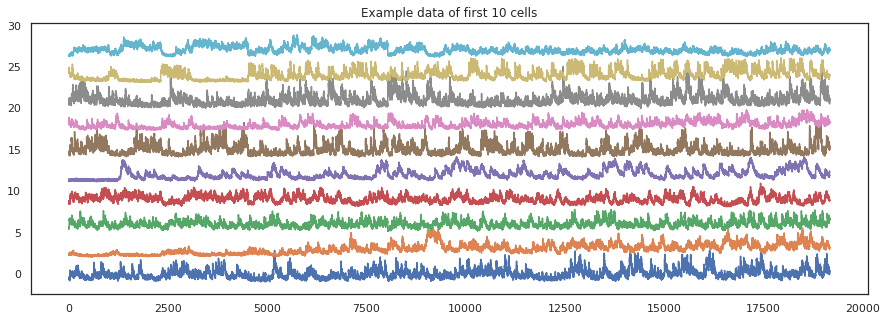

In [6]:
## Inspect data

# runs[0].__dict__.keys()

# processed (neuropil subtracted and Df/f) fluoresence matrix from first run
flu = runs[0].flu
print('This run has {} cells and {} frames'.format(flu.shape[0], flu.shape[1]))

# plot the first 10 cells in the first run
plt.figure(figsize=(15,5))
for i in range(10):
    plt.plot(flu[i,:] + i*3)
plt.title('Example data of first 10 cells')
# run objects have info from the suite2p stat (1xdictionary per cell
# used to e.g. find the plane each cell is in
plane0_idx = [idx for idx, s in enumerate(runs[0].stat) if s['iplane']==0]

# ## Find plane_0 neurons:
# # run objects have info from the suite2p stat (1xdictionary per cell
# # used to e.g. find the plane each cell is in
# plane0_idx = [idx for idx, s in enumerate(runs[0].stat) if s['iplane']==0]




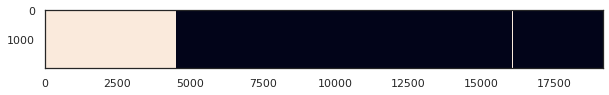

In [44]:
# plt.rcParams['figure.figsize'] = (10, 10)
# plt.plot(galvo_ms / 1e6, trial_start[:] /1e6, '.-')
# print(run_number, mouse)
# # np.isnan(galvo_ms)
# runs[0].aligner.A_to_B
# -1
# trial_start.shape
# tstart_galvo.shape
# mouse, run_number

# runs[0].frames_ms.shape
# runs[0].flu.shape
plt.imshow(np.isnan(runs[0].frames_ms))

In [25]:
## Align with  behaviour:
#### two timestamps for the onset of photostimulation ####

# when is voltage sent to the x photostimulation galvo
tstart_galvo = utils.threshold_detect(runs[0].x_galvo_uncaging, 0)

# when did the behaviour microcontroller trigger a trial start
trial_start = runs[0].trial_start
# if (run_number == 29 and mouse == 'J048') or (run_number == 29 and mouse == 'RL048'):
#     slope = (trial_start[-2] - trial_start[0]) / (tstart_galvo[-1] - tstart_galvo[0])
#     new_point = tstart_galvo[-1] + slope * (trial_start[-1] - trial_start[-2])
#     tstart_galvo = np.concatenate((tstart_galvo, new_point[np.newaxis]))

assert len(trial_start) == len(tstart_galvo)

#### these two timestamp variables are in a different reference frame ####

# run objects have an aligner method to switch between reference frames
galvo_ms = runs[0].aligner.B_to_A(tstart_galvo)

print('microcontroller trial starts occur on average {} ms from galvo trial starts'
      .format(round(np.mean(trial_start - galvo_ms), 2)))


assert runs[0].frames_ms.shape == runs[0].flu.shape

AssertionError: 

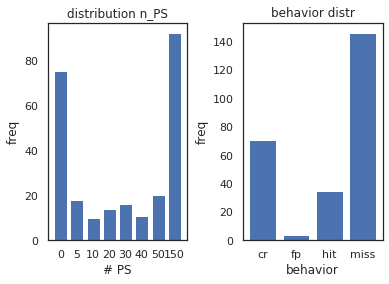

In [9]:
### a different number of cells were stimulated on each trial
### need to create a Subsets object to get this info (future code refinement will
### include this info directly in the run object
subsets = Subsets(runs[0])
trial_subsets = subsets.trial_subsets
# print(trial_subsets[5:20])
n_stim_arr = np.unique(trial_subsets)
plt.subplots_adjust(wspace=0.4)

plt.subplot(121)
plt.bar(np.arange(len(n_stim_arr)), height=[np.sum(trial_subsets == x) for x in n_stim_arr])
plt.xticks(np.arange(len(n_stim_arr)), (str(x) for x in n_stim_arr))
plt.xlabel("# PS"); plt.ylabel('freq'); plt.title('distribution n_PS')
### the result of the behavioural trial is in the run.oucome array

plt.subplot(122)
outcome = runs[0].outcome
outcome_arr = np.unique(outcome)
# print(outcome[5:20])
plt.bar(np.arange(len(outcome_arr)), height=[np.sum(outcome == x) for x in outcome_arr])
plt.xticks(np.arange(len(outcome_arr)), (str(x) for x in outcome_arr))
plt.xlabel('behavior'); plt.ylabel('freq'); plt.title('behavior distr')
assert len(runs[0].outcome) == len(tstart_galvo) == len(subsets.trial_subsets)


# licks = runs[0].session.times.get('lick_1')

In [10]:
# the number of frames before trial start to take into array
pre_frames = 20
# the number of frames after trial start to take into array
post_frames = 30
# array of fluoresence through behavioural trials (n_cells x n_trials x n_frames)
# with e.g. the first trials spanning (galvo_ms[0] - pre_frames) : (galvo_ms[0] + post_frames)
behaviour_trials = utils.build_flu_array(runs[0], galvo_ms, pre_frames, post_frames)

print(f'Shape new array : {behaviour_trials.shape}')
assert behaviour_trials.shape[1] == outcome.shape[0]

Shape new array : (1992, 256, 50)


In [11]:
behaviour_trials = behaviour_trials - np.nanmean(behaviour_trials, (1, 2))[:, np.newaxis, np.newaxis]

In [12]:
decision = np.logical_or(outcome == 'hit', outcome == 'fp').astype('int')
photostim = np.ones_like(trial_subsets)  # ones = 5-50
photostim[trial_subsets == 0] = 0
photostim[trial_subsets == 150] = 2
assert photostim.shape == decision.shape

In [13]:
n_unique_stims = len(np.unique(photostim))
n_neurons = behaviour_trials.shape[0]
n_times = behaviour_trials.shape[2]
n_trials = behaviour_trials.shape[1]
n_unique_dec = len(np.unique(decision))
occ_table = np.zeros((n_unique_stims, 2))  # stim x dec
for dec in range(n_unique_dec):
    for stim in range(n_unique_stims):
        occ_table[stim, dec] = np.sum(np.logical_and(decision == dec, photostim == stim))
n_com_trials = np.max(occ_table).astype('int')
print(occ_table)

[[71.  4.]
 [85.  4.]
 [61. 31.]]


(1992, 65, 50)
(1992, 81, 50)
(1992, 60, 50)
(1992, 4, 50)
(1992, 4, 50)
(1992, 31, 50)
(81, 1992, 2, 2, 46)


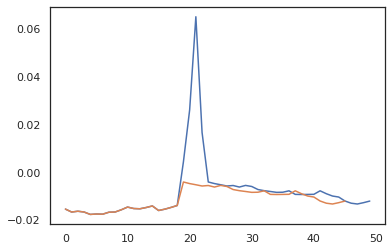

In [14]:
activity = np.zeros((n_com_trials, n_neurons, n_unique_stims, n_unique_dec, n_times))
activity = activity * np.nan
nan_trials = np.isnan(np.mean(behaviour_trials, (0, 2)))
min_common = 100
max_common = 0
for dec in range(n_unique_dec):
    for stim in range(n_unique_stims):
        inds_cond = np.logical_and(decision == dec, photostim == stim)
        inds_cond = np.logical_and(inds_cond, np.logical_not(nan_trials))
        current_data = np.squeeze(behaviour_trials[:, inds_cond, :])
        n_curr_trials = current_data.shape[1]
        activity[:n_curr_trials, :, stim, dec, :] = np.swapaxes(current_data, 0, 1)
        max_common = np.maximum(max_common, current_data.shape[1])
        min_common = np.minimum(min_common, current_data.shape[1])
        print(current_data.shape)
# n_com_trials = np.minimum(n_com_trials, min_common)
n_com_trials = np.minimum(n_com_trials, max_common)

activity = activity[:n_com_trials, :, :, :, :]
n_unique_stims = 2
activity = activity[:, :, :n_unique_stims, :, :]  # filter out PS = 150 trials
filter_ps_array = np.concatenate((np.arange(19), np.arange(23, 50)))  # filter out few frames around PS
old_act = activity.copy()
activity = activity[:, :, :, :, filter_ps_array]
activity_av = np.nanmean(activity, 0)

plt.plot(np.nanmean(old_act, (0, 1, 2, 3)), label='activity all times')
plt.plot(np.nanmean(activity, (0, 1, 2, 3)), label='activity filtered times')
print(activity.shape)

In [149]:
dpca = dPCA.dPCA(labels='sdt', n_components=5, regularizer='auto')
dpca.protect = ['t']

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.


In [150]:
Z = dpca.fit_transform(activity_av, activity)

Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.003388200529767837
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


KeyError: 's'

<Figure size 864x936 with 0 Axes>

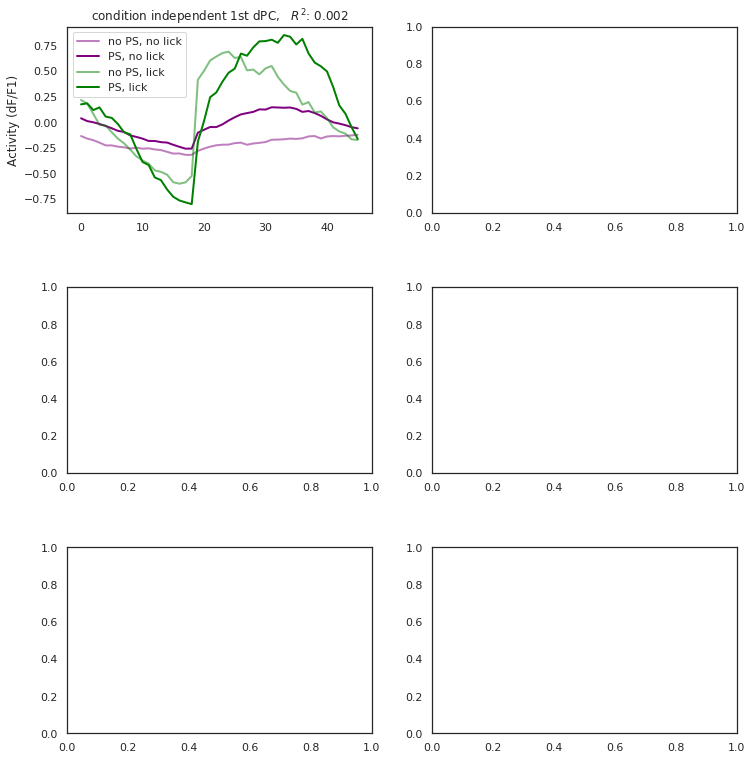

In [186]:
dec_color = {0: 'purple', 1: 'green'}
stim_linestyle = {0: '-', 1: '-'}
stim_alpha = {0: 0.5, 1: 1, 2: 1}
title_cond = {'t': 'condition independent', 's': 'photo-stimulus dependent',
              'd': 'lick decision dependent', 'sd': 'lick / PS interaction'}
label_cond = {'stim': {0: 'no PS', 1: 'PS'}, 'dec': {0: 'no lick', 1: 'lick'}}
expl_var=0

def plot_condition(ax, cond):
    """Function to plot 1 condition on axis object ax"""
    
        
    for dec in range(n_unique_dec):  # loop through all conditions
        for stim in range(n_unique_stims):
            plot_array = None
            plot_array = Z[cond][0, stim, dec, :].copy()  # data to plot
            expl_var = dpca.explained_variance_ratio_[cond][0].copy()  # extra 
            if cond != 't':
                plot_array += Z[cond + 't'][0, stim, dec, :].copy()
                expl_var += dpca.explained_variance_ratio_[cond + 't'][0].copy()
            # check Z over time
            # return ax?
            ax.plot(plot_array, label=f'{label_cond["stim"][stim]}, {label_cond["dec"][dec]}',
                     linestyle=stim_linestyle[stim], c=dec_color[dec], alpha=stim_alpha[stim], linewidth=2)
    if i_row == 1:
        ax.set_xlabel('Time (frames)'); 
    if i_col == 0:
        ax.set_ylabel('Activity (dF/F1)'); 
    ax.set_title(title_cond[cond] + f' 1st dPC,   $R^2$: {np.round(expl_var, 3)}')
    if i_row == 0 and i_col == 0:
        ax.legend()
        
    if cond == 's':
        return Z[cond][0, :, :, :]
    else:
        return None
#         it_z += 1
# TODO: plot gap of PS
plt.rcParams['figure.figsize'] = (12, 13)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig, axes = plt.subplots(3, 2, gridspec_kw={'hspace': 0.4})

for i_row in range(2):
    for i_col in range(2):
        save_z[it_z] = plot_condition(axes[i_row][i_col], list(title_cond.keys())[2 * i_row + i_col])
        it_z += 1
plt.subplot(3, 2, 5)
sns.heatmap(occ_table, annot=True, xticklabels=['no lick', 'lick'], 
            yticklabels=['no PS', '5-50 PS', '150 PS (excl.)'])
# plt.set_xticklabels(['no lick', 'lick'])
plt.yticks(rotation=0)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.title('Occurence table')
# plt.show() # ta-da!
plt.savefig(f'dPCA_{mouse}_{run_number}.pdf') 

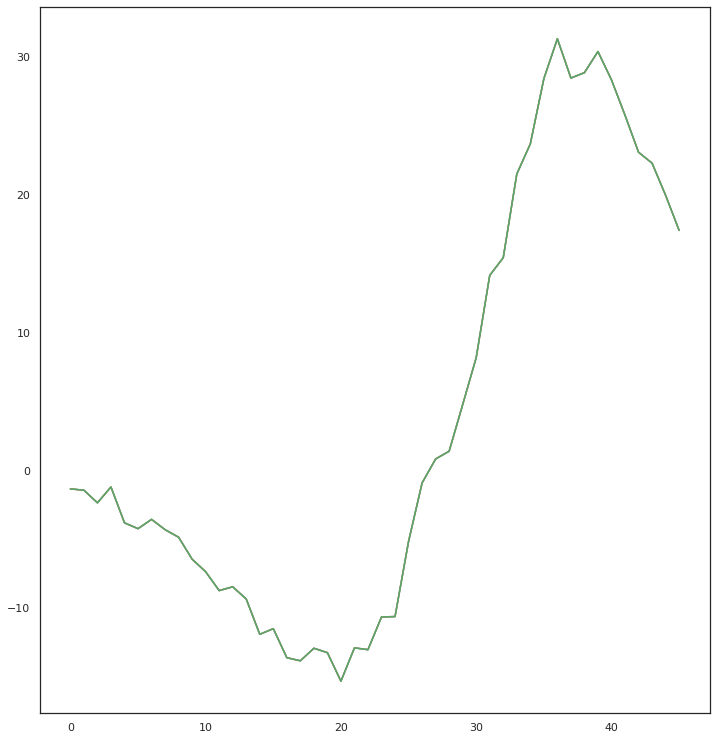

In [137]:
# tmp_save_z = {k: v for k, v in save_z.items() if v is not None}
plt.plot(tmp_save_z[1][1, 1, :])
plt.plot(tmp_save_z[33][1, 1, :])
# tmp_save_z.keys
plt.plot(Z['s'][0, 1, 1, :])

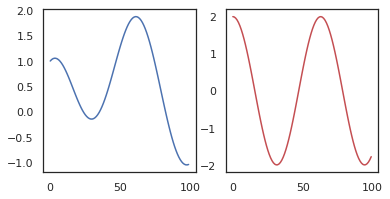

In [170]:
tmp_data = {0: np.sin(np.arange(100) / 30), 1: np.cos(np.arange(100) / 10)}

def tmp_plot(ax, c):
    plot_array = tmp_data[c]    
    plot_array += tmp_data[1]
    if c == 0:
        ax.plot(plot_array, 'b')
    elif c == 1:
        ax.plot(plot_array, 'r')
    
plt.rcParams['figure.figsize'] = (6, 3)
fig, axes = plt.subplots(1, 2)
for ii in [0, 1]:
    tmp_plot(axes[ii], ii)
    

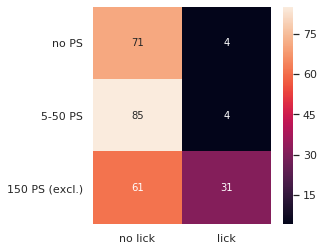

In [30]:
plt.rcParams['figure.figsize'] = (4, 4)
sns.heatmap(occ_table, annot=True, xticklabels=['no lick', 'lick'], 
            yticklabels=['no PS', '5-50 PS', '150 PS (excl.)'])
# plt.set_xticklabels(['no lick', 'lick'])
plt.yticks(rotation=0)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

## Prelim conclusions: 
- Unclear how correction for data set size imbalance works? Results sort of differ => due to optimizer?
- Taking out stim=2 does not really change the others.. Jimmy argued it's a good idea to take these out
- Relation to weights (uni-signed?) => add some example neurons?



In [181]:
recon = {}
recon['st'] = (dpca.reconstruct(activity_av, marginalization='st') +
               dpca.reconstruct(activity_av, marginalization='s'))
recon['dt'] = (dpca.reconstruct(activity_av, marginalization='dt') +
               dpca.reconstruct(activity_av, marginalization='d'))
recon['sdt'] = (dpca.reconstruct(activity_av, marginalization='sdt') +
               dpca.reconstruct(activity_av, marginalization='sd'))
recon['t'] = dpca.reconstruct(activity_av, marginalization='t')
recon['full'] = np.zeros_like(recon['st'])
for cond in ['t', 'st', 'dt', 'sdt']:
    recon['full'] += recon[cond]

[ 842  533    6  606 1344]


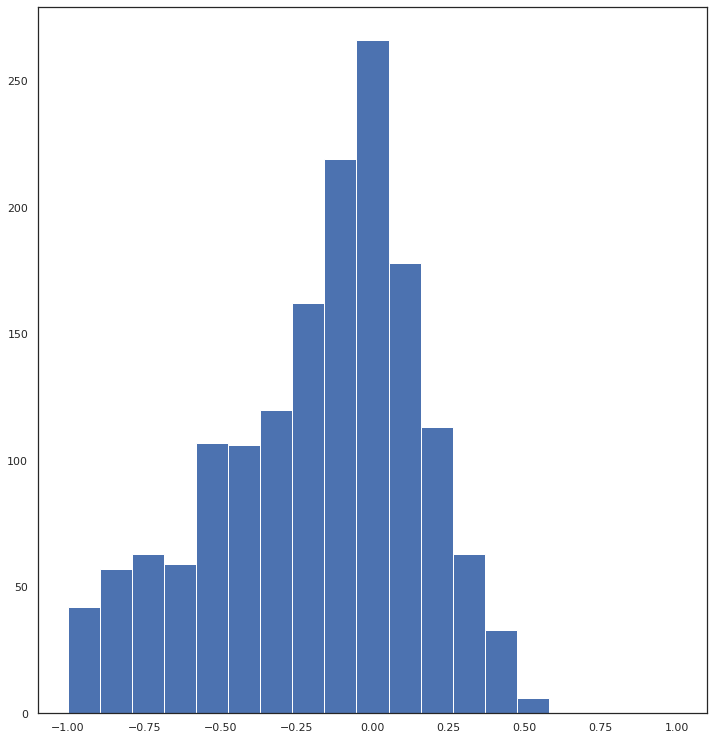

In [185]:
r2_dpca =  1- (np.mean(np.power(activity_av - recon['full'], 2), (1, 2, 3)) /
            np.mean(np.power(activity_av - np.mean(activity_av, 3)[:, :,:, np.newaxis], 2), (1, 2, 3)))
plt.hist(r2_dpca, bins=np.linspace(-1, 1, 20));
print(np.argsort(r2_dpca)[-5:])
# print(r2_dpca[33])
# plt.xlim([0, 1])

R2 of neuron 715: 0.658


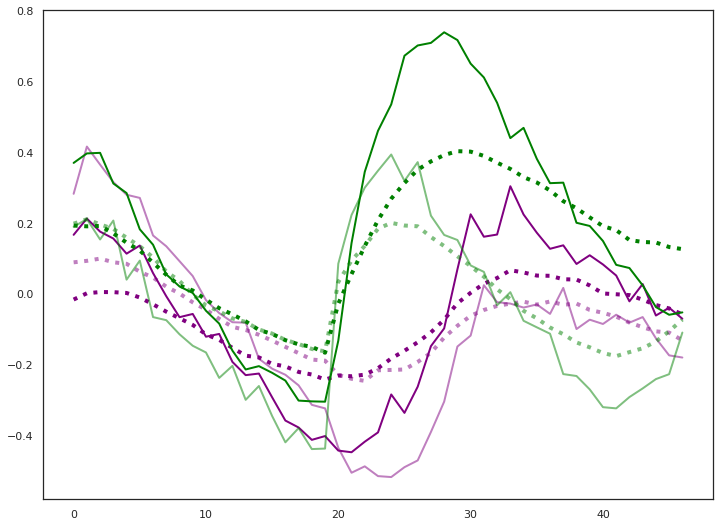

In [246]:
neuron_id = 715

print(f'R2 of neuron {neuron_id}: {np.round(r2_dpca[neuron_id], 3)}')

for dec in range(n_unique_dec):  # loop through all conditions
    for stim in range(n_unique_stims):
        plt.plot(activity_av[neuron_id, stim, dec, :],label=f'{label_cond["dec"][dec]}',
                     c=dec_color[dec], alpha=stim_alpha[stim], linewidth=2)
        plt.plot(recon['full'][neuron_id, stim, dec, :], ':', label=f'{label_cond["dec"][dec]}',
                     c=dec_color[dec], alpha=stim_alpha[stim], linewidth=4)

(2101,)


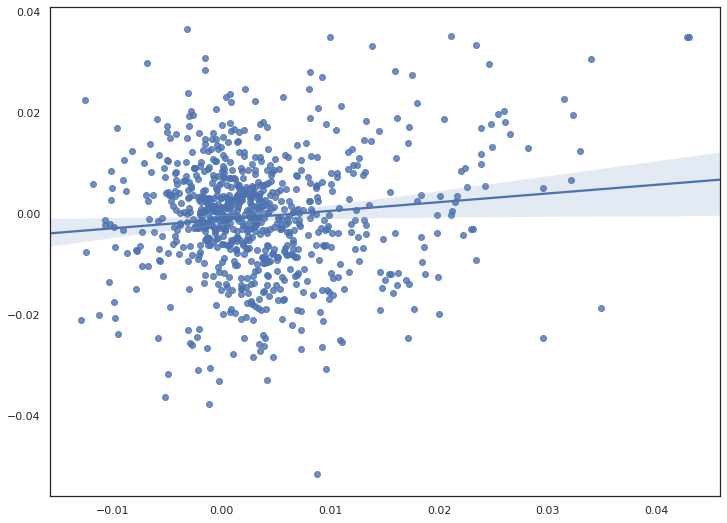

In [215]:
print((dpca.D['s'] + dpca.D['st'])[:, 0].shape)
inds_pos_r2 = np.where(r2_dpca > 0)[0]
sns.regplot(dpca.D['t'][inds_pos_r2, 0],   #(dpca.D['s'] + dpca.D['st'])[inds_pos_r2, 0],
            (dpca.D['d'] + dpca.D['dt'])[inds_pos_r2, 0])

In [218]:
# np.argsort((dpca.D['d'] + dpca.D['dt'])[inds_pos_r2, 0])[-5:]
dpca.D

{'s': array([[ 3.24018519e-03,  1.01643954e-19, -1.69406589e-20,
         -3.38813179e-20, -1.30443074e-19],
        [-1.73179906e-02,  5.42101086e-20, -2.30392962e-19,
         -7.04731412e-19,  8.53809211e-19],
        [-7.72924213e-04,  9.82558219e-20,  8.63973606e-20,
         -1.16890547e-19, -1.65171425e-20],
        ...,
        [-2.22032699e-03,  4.74338450e-20,  8.63973606e-20,
         -3.55753838e-19, -1.01643954e-20],
        [ 2.36063342e-03,  1.21972744e-19, -9.82558219e-20,
          2.03287907e-19, -1.21125711e-19],
        [-5.21740256e-03,  1.35525272e-20,  2.10064171e-19,
         -5.69206141e-19,  1.76182853e-19]]),
 'd': array([[-7.53651088e-03, -3.23566586e-19, -5.14996032e-19,
          2.10064171e-19, -2.33781093e-19],
        [-2.09528203e-02, -1.16551734e-18, -8.67361738e-19,
         -9.48676901e-19, -1.35525272e-18],
        [-3.33392351e-02, -2.83247818e-18, -3.14418630e-18,
          6.50521303e-19,  6.77626358e-20],
        ...,
        [ 5.53053057e-03, 